# Exploratory Data Analysis
## - Spot frequent patterns (uni-grams, bi-grams, tri-grams)
## - Spot important keyword for all the groups
## - Analysing data based on language
## - Understanding what can be excluded from the given data
## - Generating feature set

In [1]:
# import libs

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
import warnings
import nltk
from spellchecker import SpellChecker
from langdetect import detect
from scipy.stats import zscore
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans


%matplotlib inline
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)
plt.style.use('dark_background')

plotting_config = params = {
                                'legend.fontsize': 'large',
                                'figure.figsize': (20, 10),
                                'axes.labelsize': 'large',
                                'axes.titlesize':'x-large',
                                'xtick.labelsize':'x-large',
                                'ytick.labelsize':'x-large'
                            }

plt.rcParams.update(plotting_config)

### Creating default variables & place holders for later user

In [2]:
# initial setup for text-processing, creating an english vocab
# find corpora @ http://www.nltk.org/nltk_data/
words_corpus = set(w.lower() for w in nltk.corpus.words.words())
wordnet_corpus = set(w.lower() for w in nltk.corpus.wordnet.words())
english_vocab = words_corpus.union(wordnet_corpus)
ISO_LANGUAGE_CODES = {x['alpha2']: x['English'].split(';')[0] 
                      for x in list(pd.read_csv('language_codes.csv').T.to_dict().values())}
language_to_code = {val: key for key, val in ISO_LANGUAGE_CODES.items()}
lemmatizer = nltk.stem.WordNetLemmatizer()
setmmer = nltk.stem.PorterStemmer()
stopwords = nltk.corpus.stopwords.words()
word_dict = {}
spell_checker = {}
outlier_tokens = []
try:
    spelling_corrections = pd.read_pickle('spell_check.pkl')
    for i in range(spelling_corrections.shape[0]):
        spell_checker[spelling_corrections.iloc[i, 0]] = spelling_corrections.iloc[i, 1]
except:
    pass

### Load dataset

In [3]:
# reading data
data = pd.read_pickle('cleaned_data.pkl')
data.index = list(range(data.shape[0]))
data['group_id'] = data.assignment_group.apply(lambda x: int(str(x).split('_')[1]))
user_ids = ' '.join(data.caller.values.tolist()).split()
data.head()

,short_description,description,caller,assignment_group,cleaner_short_description,cleaner_description,language,merged_text,unusual_words,tokenized_text,group_id
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0,login issue,confirm verify password issue check able emplo...,english,login issue confirm verify password issue chec...,[],"[login, issue, confirm, verify, password, issu...",0
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0,outlook,meet please kind somebody skype outlook calend...,english,outlook meet please kind somebody skype outloo...,"[skype, etc]","[outlook, meet, please, kind, somebody, skype,...",0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0,cant log vpn,log cannot receive best vpn,english,cant log vpn log cannot receive best vpn,[],"[cant, log, vpn, log, cannot, receive, best, vpn]",0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0,unable access tool page,unable access tool page,english,unable access tool page unable access tool page,[],"[unable, access, tool, page, unable, access, t...",0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0,error skype,error skype,english,error skype error skype,[skype],"[error, skype, error, skype]",0


#### Total tokens

In [4]:
# understanding frequency distribution of all words
merged_text = data.merged_text.str.cat(sep=' ')
tokens = nltk.word_tokenize(merged_text)
fdist = nltk.probability.FreqDist(tokens)
print(f'Total number of tokens present: {len(tokens)}')

Total number of tokens present: 143060


### An exception list & a keyword list
### Generated after extensive data analysis
#### Top keyword will be preserved
#### Exclude list will be dropped

In [5]:
exclude_list = ['recieve', 'please', 'name', 'work', 'use', 'call', 'mail', 'new', 'team',
                'see', 'able', 'try', 'can', 'since', 'not', 'best', 'in', 'to', 'could', 'also', 'dear',
                'yes', 'one', 'enter', 'know', 'back', 'top', 'would', 'let', 'set', 'der', 'go', 'make', 'und',
                'still', 'aber', 'enimal', 'please', 'etc', 'kind', 'kindly', 'welcome'
               ]

top_keywords = ['job', 'scheduler', 'password', 'login', 'skype', 'outlook', 'abap', ]

### Some utility functions

In [6]:
def remove_special_chars(text):
    try:
        text = ' '.join(re.findall(r'\w+', text)).lower()
        for char in punctuation:
            if char in text:
                text = re.sub(char, ' ', text)
        text = text.replace('\n', '').replace('\r', '').replace('\t', '')
        text = remove_extra_spaces(text)
    except Exception as e:
        e = f'Special character remover crashed at text: {text} | Err Msg={e}'
    return text


def get_frequency_distribution(text):
    if type(text) == str:
        text = text.split()
    if type(text) not in [list, tuple, set]:
        raise ValueError(f'non iterable args: {type(text)}')
    return nltk.probability.FreqDist(tokens)

def get_most_common_keywords(text, n=None):
    if type(text) == str:
        text = text.split()
    if type(text) not in [list, tuple, set]:
        raise ValueError(f'non iterable args: {type(text)}')
    fdist = get_frequency_distribution(text)
    return fdist.most_common()[:n or len(text)]


def get_most_common_bi_grams(text, n=None):
    if type(text) == str:
        text = text.split()
    if type(text) not in [list, tuple, set]:
        raise ValueError(f'non iterable args: {type(text)}')
    bi_grams = list(nltk.bigrams(text))
    print('here: ', bi_grams[670])
    fdist = get_frequency_distribution(bi_grams)
    return fdist.most_common()


def get_most_common_n_grams(text, n=1, top_n=None):
    if type(text) == str:
        text = text.split()
    if type(text) not in [list, tuple, set]:
        raise ValueError(f'non iterable args: {type(text)}')
    n_grams = list(nltk.ngrams(text, n))
    fdist = get_frequency_distribution(n_grams)
    return fdist.most_common()[:top_n or len(text)]


def get_data_range(data, lower_limit=0.05, upper_limit=0.95):
    lower_q = data.quantile(q=lower_limit)
    upper_q = data.quantile(q=upper_limit)
    return lower_q, upper_q
    
    
def get_all_possible_words(complex_word):
    words_detected = []
    try:
        complex_word = remove_special_chars(complex_word).replace(' ', '')
        for i in range(len(complex_word)):
            current_char = complex_word[i]  # pick the first char
            for j in range(i+1, len(complex_word)):
                other_chars = complex_word[i+1:j+1]  # pick all other chars
                possible_word = current_char + other_chars  # form all possible combinations
                if possible_word in english_vocab:
                    words_detected.append(possible_word)
        words_detected = set(words_detected)
    except Exception as e:
        print(f'All possible words generator crashed, Err Msg={e}')
    return words_detected

    
def get_char_map(complex_word, word_list=None, sort=True, reverse=True):
    char_map = {}
    try:
        if not bool(word_list):
            word_list = get_all_possible_words(complex_word)
        complex_word = remove_special_chars(complex_word).replace(' ', '')
        for char in set(complex_word):
            if char not in char_map:
                words_by_char = set(list(filter(lambda x: x.startswith(char), word_list)))
                if sort:
                    words_by_char = sorted(words_by_char, key=len, reverse=reverse)
                char_map[char] = words_by_char
    except Exception as e:
        print(f'Char map generator crashed, Err Msg={e}')
    return char_map
    
def extract_possible_words(complex_word, char_map=None, word_list=None):
    '''
        try extracting meaningful words from contactenated string
        ex: 'passwordmanagementtool' -> ['password', 'management', 'tool']
    '''
    extracted_words = []
    try:
        if word_list is None:
            word_list = get_all_possible_words(complex_word)
        if not bool(char_map):
            char_map  = get_char_map(complex_word, word_list=word_list)
        
        target_word = remove_special_chars(complex_word).replace(' ', '')
        for i in range(len(complex_word)):
            first_char = target_word[0]
            possible_words = char_map.get(first_char)
            if bool(possible_words):
                for word in possible_words:
                    if target_word.startswith(word):
                        if word not in extracted_words:
                            extracted_words.append(word)
                            target_word = target_word[len(word):]
                            break
#                       else:
#                           target_word = target_word[len(word):]
            else:
                target_word = target_word[1:]
            if len(target_word) <= 1:
                break
    except Exception as e:
        print(f'Words extractor crashed, Err Msg={e}')
    return extracted_words


def get_tfidf(data):
    try:
        vectorizer = TfidfVectorizer()
        vectors = vectorizer.fit_transform(data)
        tfidf = pd.DataFrame(vectors.toarray(), columns=vectorizer.get_feature_names())
        return tfidf
    except Exception as e:
        print(e)

        
def determine_word_value(word, tfidf):
    if word not in tfidf.keys():
        raise ValueError('word not found in tfidf')
    temp = tfidf[tfidf[word] > 0]
    mean_of_all_words = temp[list(filter(lambda x: temp[x].mean() > 0, temp.keys()))].mean().values.mean()
    

## Exploring use cases around token distribution
### We're trying to spot some outliers
#### Either values that are extremely high in distribution
#### Or values that are exceptionally low

In [7]:
word_distribution = []
total_tokens = len(set(tokens))
for word, count in fdist.most_common():
    word_distribution.append((word, count, round(count / total_tokens, 6)))

In [8]:
avg_distribution = round(100 / total_tokens, 6)
avg_distribution

0.010467

In [9]:
# distribution for each unique token
word_distribution = pd.DataFrame(word_distribution, columns=['word', 'occurences', 'distribution'])
word_distribution.head()

,word,occurences,distribution
0,receive,2511,0.262822
1,job,2027,0.212162
2,please,1998,0.209127
3,password,1966,0.205778
4,scheduler,1926,0.201591


In [10]:
# overall distribution
word_distribution.describe().T

,count,mean,std,min,25%,50%,75%,max
occurences,9554.0,14.973833,84.662173,1.000000,1.000000,2.000000,4.000000,2511.000000
distribution,9554.0,0.001567,0.008861,0.000105,0.000105,0.000209,0.000419,0.262822


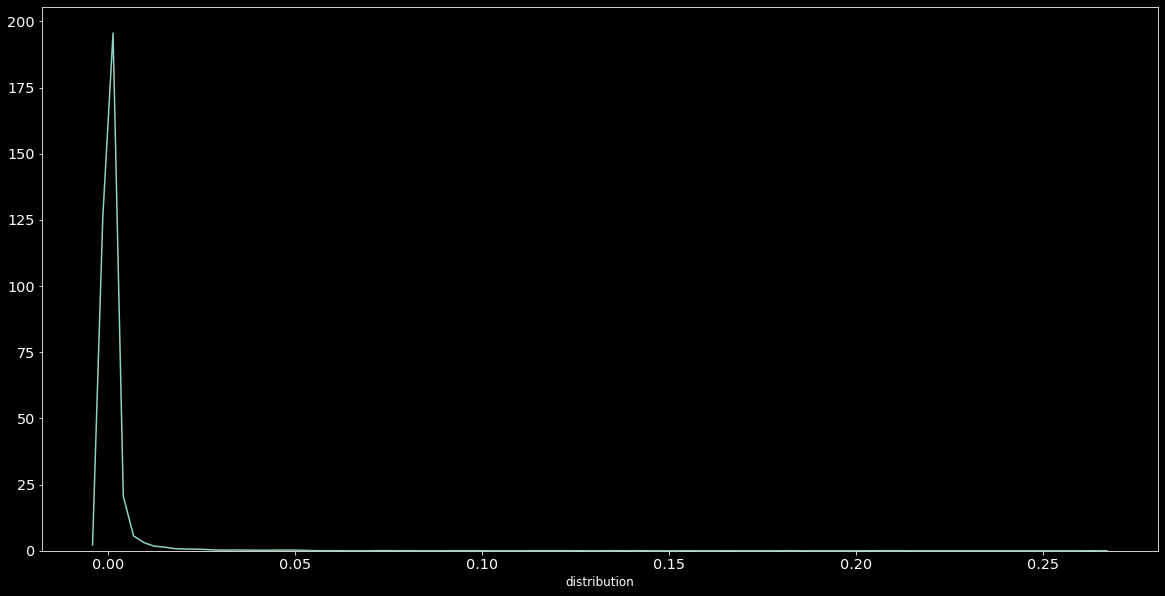

In [11]:
# plotting distribution of tokens
# we can see that is heavily skewed to left
# indicating that a few token dominating the distribution
sns.distplot(word_distribution.distribution, hist=False)
plt.show()

### Working with data that is withing inter-quantile range(5-99%)

In [12]:
# selecting quantile range: 5% - 99%
q1, q99 = get_data_range(word_distribution.occurences, upper_limit=0.99)
# getting rid of some outliers
target_set = word_distribution[(word_distribution.occurences > q1) & (word_distribution.occurences < q99)]

# let's check how much data have we dropped
fraction_dropped = round((1 - (target_set.shape[0] / word_distribution.shape[0])) * 100, 1)
print(f'Dropped about {fraction_dropped} % data.')

Dropped about 46.0 % data.


In [13]:
# we can see that we have already dropped almost half of the data
# tells us that there were alot of exceptional cases
# we'll further analyse the dropped values
# looking through the data that we've collected

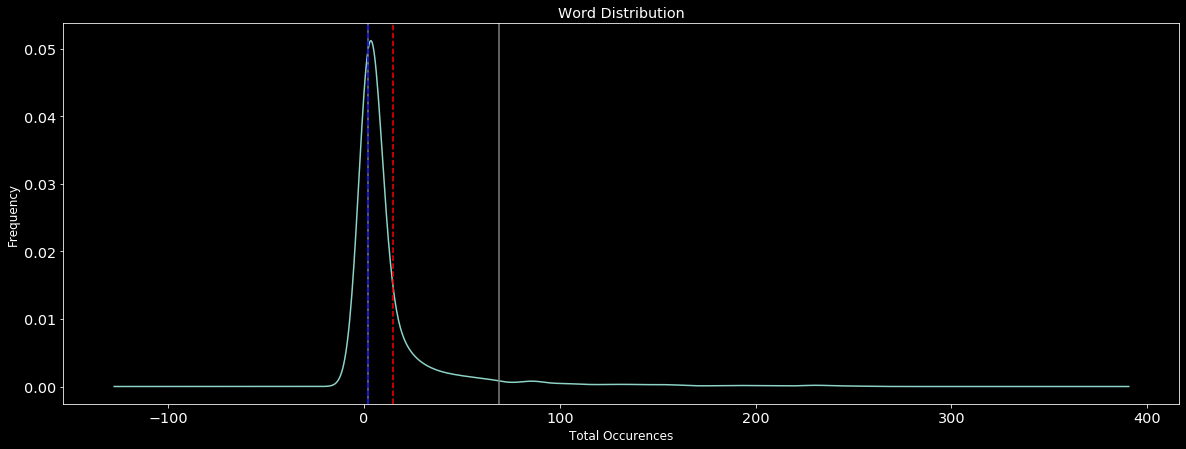

In [14]:
# plotting common words
# grey lines indicate the soace where most common keywords are present
# red line indicates mean value, which is inclined towards left side
# blue line indicates mean value, it overlaps with the left grey line
# indicating that there're a few keyword with a exceptionally high  distribution
target_set.occurences.plot(kind='kde', figsize=(20, 7), title='Word Distribution')
m1, m2 = get_data_range(target_set.occurences)
plt.axvline(m1, color='grey', linestyle='-')
plt.axvline(m2, color='grey', linestyle='-')
plt.xlabel('Total Occurences')
plt.ylabel('Frequency')
plt.axvline(word_distribution.occurences.mean(), color='r', linestyle='--')
plt.axvline(word_distribution.occurences.median(), color='b', linestyle='--')
plt.show()

In [15]:
# plot above tells us that majority of the values present in the right half
# let's take a look at them
low_frequency_words = target_set[target_set.occurences <= word_distribution.occurences.mean()]

# fraction of low frequency words
fraction = low_frequency_words.shape[0] / data.shape[0]
fraction_ = round(fraction * 100, 1)
print(f'Low frequency word make up for about: {fraction_} % of data.')

Low frequency word make up for about: 48.4 % of data.


In [16]:
# we only had about 54% of data, impling that only about 6% data has been further dropped
# trying to spot anamolies in low frequency words
low_frequency_words.describe().T

,count,mean,std,min,25%,50%,75%,max
occurences,4110.0,4.012409,2.892255,2.000000,2.000000,3.000000,5.000000,14.000000
distribution,4110.0,0.000420,0.000303,0.000209,0.000209,0.000314,0.000523,0.001465


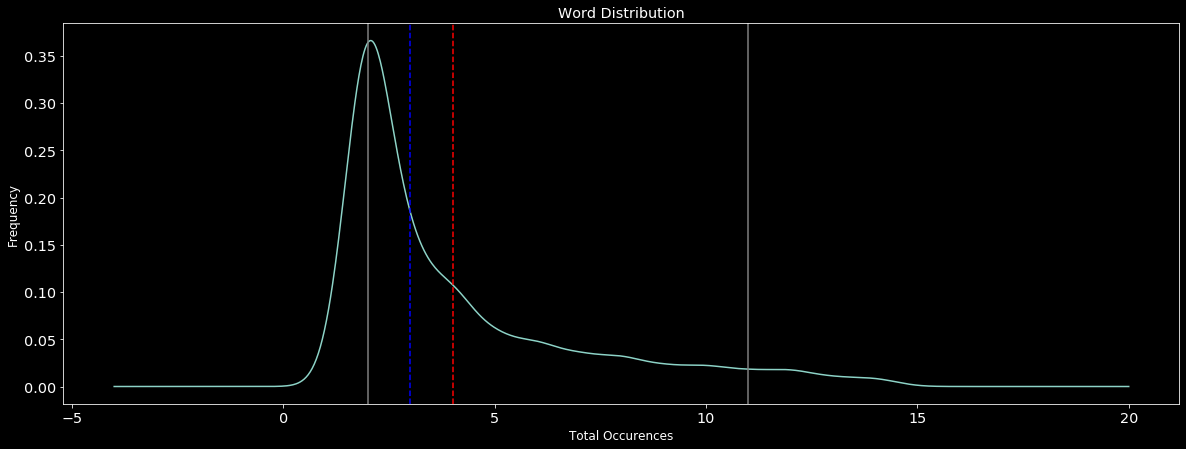

In [17]:
# plotting the distribution
low_frequency_words.occurences.plot(kind='kde', figsize=(20, 7), title='Word Distribution')
m1, m2 = get_data_range(low_frequency_words.occurences)
plt.axvline(m1, color='grey', linestyle='-')
plt.axvline(m2, color='grey', linestyle='-')
plt.xlabel('Total Occurences')
plt.ylabel('Frequency')
plt.axvline(low_frequency_words.occurences.mean(), color='r', linestyle='--')
plt.axvline(low_frequency_words.occurences.median(), color='b', linestyle='--')
plt.show()

## Observations made so far:
#### - Still the same pattern is visible, a skewness to left
#### - Data description highlights the same fact
#### - Indicating that data distribution will still be dominated
#### - By a handful of keyword that occur more often
#### - Trucating the data further

In [18]:
low_frequency_words.describe().T

,count,mean,std,min,25%,50%,75%,max
occurences,4110.0,4.012409,2.892255,2.000000,2.000000,3.000000,5.000000,14.000000
distribution,4110.0,0.000420,0.000303,0.000209,0.000209,0.000314,0.000523,0.001465


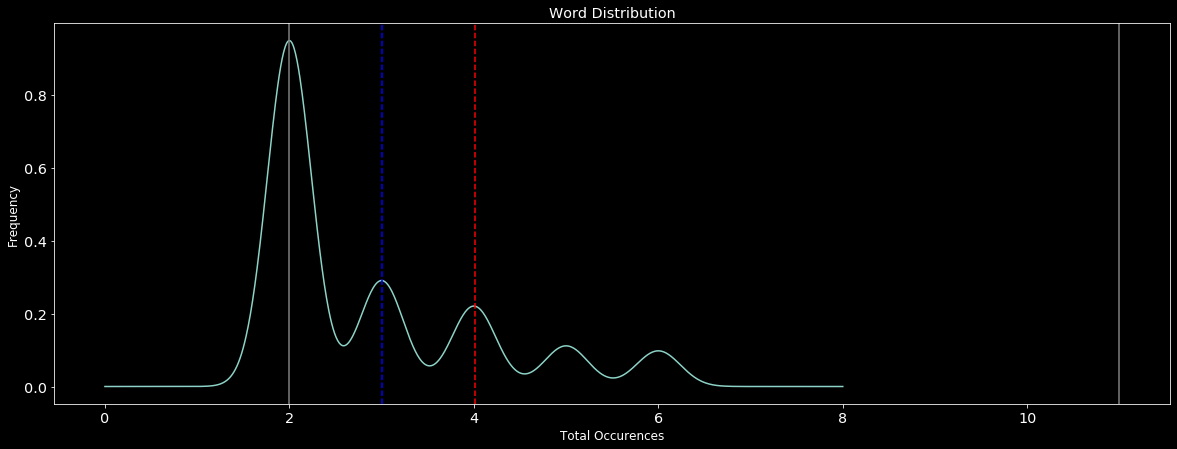

In [19]:
# high to low pattern has become much more evident now
# this pattern is not something new with Natural Language, exhibitted by almost all languages
# relevance of the words descreases in an proportional manner
# plotting the distribution
low_frequency_words[low_frequency_words.occurences < 7].occurences.plot(kind='kde', figsize=(20, 7), title='Word Distribution')
m1, m2 = get_data_range(low_frequency_words.occurences)
plt.axvline(m1, color='grey', linestyle='-')
plt.axvline(m2, color='grey', linestyle='-')
plt.xlabel('Total Occurences')
plt.ylabel('Frequency')
plt.axvline(low_frequency_words.occurences.mean(), color='r', linestyle='--')
plt.axvline(low_frequency_words.occurences.median(), color='b', linestyle='--')
plt.show()

In [20]:
low_frequency_words.head()

,word,occurences,distribution
1147,payslip,14,0.001465
1148,static,14,0.001465
1149,dhcp,14,0.001465
1150,meeting,14,0.001465
1151,conn,14,0.001465


## Trying to extract outliers from low frequency token

In [21]:
# let's examine these low frequency tokens
# data where merged text conatins a low frequency word
low_frequency_container = data[data.tokenized_text.apply(lambda x: bool(len(set(x).intersection(low_frequency_words.word.values.tolist()))))]

# fraction covered
fraction = low_frequency_container.shape[0] / data.shape[0]
fraction_ = round(fraction * 100, 1)
print(f'Low frequency tokens are spread over {fraction_}% of the data.')
print(f'Shape: {low_frequency_container.shape[0]} X {low_frequency_container.shape[1]}')


Low frequency tokens are spread over 47.5% of the data.
Shape: 4033 X 11


In [22]:
# group wise distribution
# we can observe a steep descending pattern again
group_wise_distribution_low = low_frequency_container.assignment_group.value_counts().to_frame()
group_wise_distribution_low.reset_index(inplace=True)
group_wise_distribution_low.columns = ['group', 'occurences']
group_wise_distribution_low

,group,occurences
0,GRP_0,1440
1,GRP_2,184
2,GRP_24,177
3,GRP_8,170
4,GRP_12,168
...,...,...
68,GRP_73,1
69,GRP_67,1
70,GRP_71,1
71,GRP_61,1


In [23]:
# data above tells us how many data points for each group contain at least one low frequency word
# let's try and see what frcation of data is occupied for each group
group_wise_distribution_low['total_fraction'] = group_wise_distribution_low.apply(lambda x: round(x.occurences / data.assignment_group.value_counts()[x.group], 1), axis=1)
group_wise_distribution_low.head()

,group,occurences,total_fraction
0,GRP_0,1440,0.4
1,GRP_2,184,0.8
2,GRP_24,177,0.6
3,GRP_8,170,0.3
4,GRP_12,168,0.7


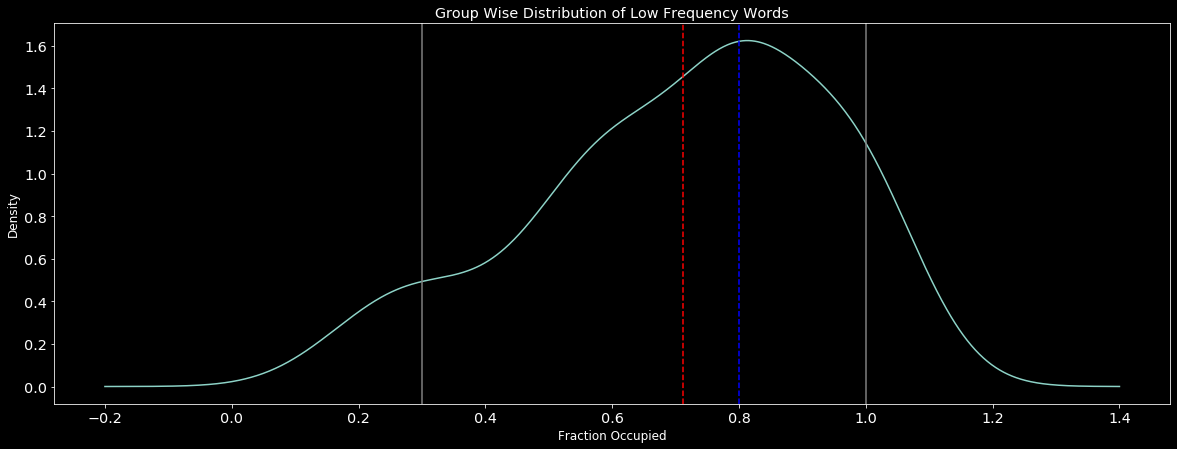

In [24]:
# plotting the distribution
group_wise_distribution_low.total_fraction.plot(kind='kde', figsize=(20, 7), title='Group Wise Distribution of Low Frequency Words')
m1, m2 = get_data_range(group_wise_distribution_low.total_fraction)
plt.axvline(m1, color='grey', linestyle='-')
plt.axvline(m2, color='grey', linestyle='-')
plt.xlabel('Fraction Occupied')
plt.axvline(group_wise_distribution_low.total_fraction.mean(), color='r', linestyle='--')
plt.axvline(group_wise_distribution_low.total_fraction.median(), color='b', linestyle='--')
plt.show()

## Exclusing outlier values
### Tokens that we're looping throug are low frequency tokens

In [25]:
unique_groups = low_frequency_container.assignment_group.unique().tolist()
temp = low_frequency_container#[low_frequency_container.assignment_group == group]
target_data = low_frequency_container
target_words = low_frequency_words.word.values.tolist()#[:1000]
total_words = len(target_words)
outlier_tokens = []
if not(bool(outlier_tokens)):
    for i in range(total_words):
        try:
            word = target_words[i]
            print(f'{i+1} / {total_words}', end='\r')
            temp = target_data[target_data.tokenized_text.apply(lambda x: word in x)]
            tf = get_tfidf(temp.merged_text)
            overall_mean = tf.mean().mean()
            word_mean = tf[word].mean()
            if word_mean < overall_mean:
                if word not in outlier_tokens:
                    outlier_tokens.append(word)
        except Exception as e:
            print(e, i)
            raise e
            break

In [26]:
len(outlier_tokens)

415

## Extracting  outliers from high frequency tokens
### Here we're going to see a lot of overlap in data points
### Plus trying to spot keyword that hold determinitsic value

In [27]:
# separating high frequency words
high_frequency_words = word_distribution[word_distribution.occurences > word_distribution.occurences.mean()]
high_frequency_words.head()

,word,occurences,distribution
0,receive,2511,0.262822
1,job,2027,0.212162
2,please,1998,0.209127
3,password,1966,0.205778
4,scheduler,1926,0.201591


In [28]:
# extracting data that contains high frequency tokens
high_frequency_container = data[data.tokenized_text.apply(lambda x: bool(set(x).intersection(high_frequency_words.word.values.tolist())))]

# fraction covered
fraction = high_frequency_container.shape[0] / data.shape[0]
fraction_ = round(fraction * 100, 1)
print(f'High frequency tokens are spread over {fraction_}% data.')

High frequency tokens are spread over 99.1% data.


In [29]:
# now since we're going to deal with high frequency tokens
# we'll create some clusters first for all the tokens, based on their occurence & over all disribution
cluster_range = range(1, 20)
cluster_errors = []
for num_clusters in cluster_range:
  clusters = KMeans(num_clusters, random_state=1)
  clusters.fit(high_frequency_words[['occurences', 'distribution']])
  labels = clusters.labels_
  centroids = clusters.cluster_centers_
  cluster_errors.append( clusters.inertia_ )
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors } )
clusters_df.head()

,num_clusters,cluster_errors
0,1,5.747581e+07
1,2,1.711000e+07
2,3,7.777281e+06
3,4,4.486063e+06
4,5,2.804876e+06


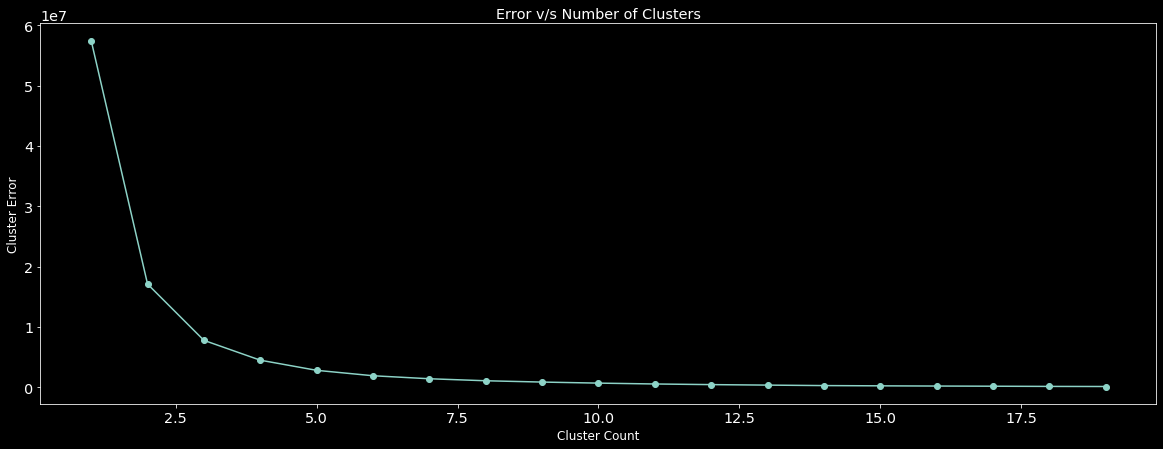

In [30]:
# looking for an optimal number of clusters
plt.figure(figsize=(20, 7))
plt.title('Error v/s Number of Clusters')
plt.xlabel('Cluster Count')
plt.ylabel('Cluster Error')
plt.plot(clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o")
plt.show()

In [31]:
# from the plot above, 7 looks like a good starting point
# creating 7 clusters
k = KMeans(n_clusters=7)
k.fit(high_frequency_words[['occurences', 'distribution']])
high_frequency_words['label'] = k.predict(high_frequency_words[['occurences', 'distribution']])

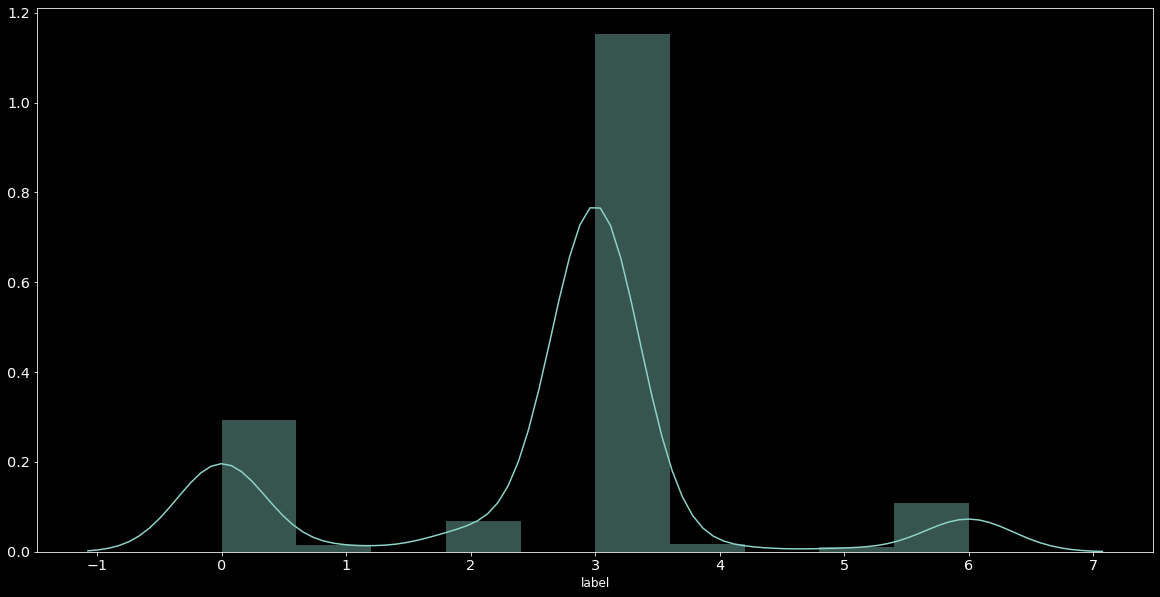

In [32]:
sns.distplot(high_frequency_words.label, bins=10)
plt.show()

In [33]:
target_words = high_frequency_words.word.values.tolist()
total_words = len(target_words)
target_data = high_frequency_container
tfidf = get_tfidf(target_data.merged_text).apply(zscore)
overall_mean = tfidf.mean().mean()

In [34]:
for i in range(total_words):
    print(f'{i+1} / {total_words}', end='\r')
    word = target_words[i]
    word_mean = tfidf[word].mean()
    fraction = abs(word_mean / overall_mean)
    if fraction >= 0.85:
        if word not in outlier_tokens:
            outlier_tokens.append(word)

tokens_to_remove = set(outlier_tokens).union(exclude_list)
tokens_to_remove = list(filter(lambda x: x not in top_keywords, tokens_to_remove))
high_frequency_words['is_outlier'] = high_frequency_words.word.apply(lambda x: x in tokens_to_remove)

In [35]:
len(tokens_to_remove)

456

### A plot to show where all the outliers lie

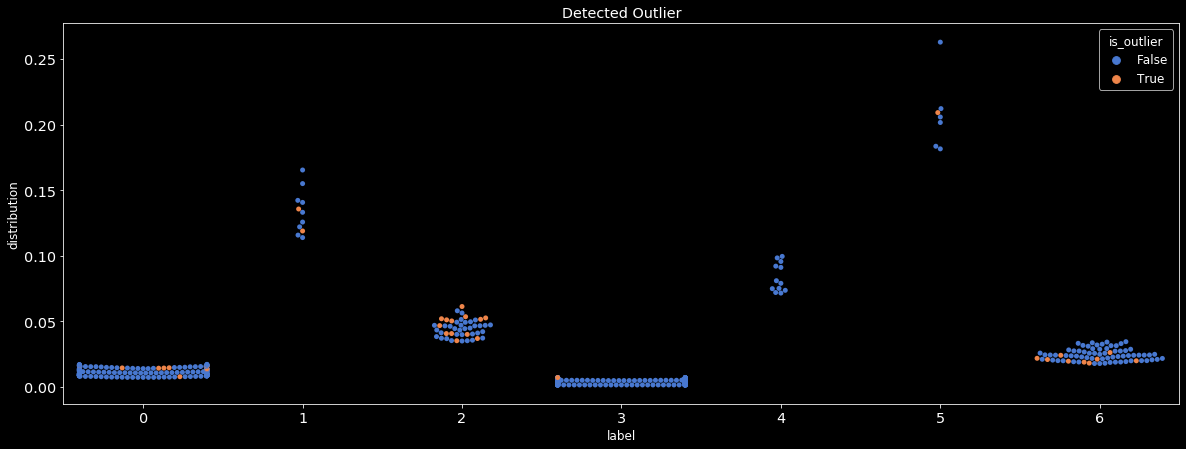

In [36]:
# now that have managed to extract some outliers from both the extreme ranges
# let's try and get a view of the values that we've marked as outliers
plt.figure(figsize=(20, 7))
sns.swarmplot(data=high_frequency_words, x="label", y='distribution', hue='is_outlier', orient='v', palette='muted')
plt.title('Detected Outlier')
plt.show()

### Cleaning up the outlier tokens from merged text

In [37]:
# now that we have collected a few outliers, we can remove them from the data set
def remove_outlier_tokens(text, outliers=[]):
    if not(bool(outliers)):
        outliers = tokens_to_remove
    try:
        for outlier in outliers:
            text = re.sub(r'\b{}\b'.format(outlier), '', text)
            text = re.sub(r'\s{2,}', ' ', text).strip()
    except:
        pass
    return text

In [38]:
data['cleaned_merged_text'] = data.merged_text.apply(remove_outlier_tokens)
data.head()

,short_description,description,caller,assignment_group,cleaner_short_description,cleaner_description,language,merged_text,unusual_words,tokenized_text,group_id,cleaned_merged_text
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0,login issue,confirm verify password issue check able emplo...,english,login issue confirm verify password issue chec...,[],"[login, issue, confirm, verify, password, issu...",0,login issue confirm verify password issue chec...
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0,outlook,meet please kind somebody skype outlook calend...,english,outlook meet please kind somebody skype outloo...,"[skype, etc]","[outlook, meet, please, kind, somebody, skype,...",0,outlook meet somebody skype outlook calendar r...
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0,cant log vpn,log cannot receive best vpn,english,cant log vpn log cannot receive best vpn,[],"[cant, log, vpn, log, cannot, receive, best, vpn]",0,cant log vpn log cannot receive vpn
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0,unable access tool page,unable access tool page,english,unable access tool page unable access tool page,[],"[unable, access, tool, page, unable, access, t...",0,unable access tool page unable access tool page
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0,error skype,error skype,english,error skype error skype,[skype],"[error, skype, error, skype]",0,error skype error skype


## Generating features

In [39]:
# now that we have cleaned the data up to a larger extent
# we can start generating feature set for the given dataset
feature_set = data[['cleaned_merged_text', 'group_id']]
feature_set.head()

,cleaned_merged_text,group_id
0,login issue confirm verify password issue chec...,0
1,outlook meet somebody skype outlook calendar r...,0
2,cant log vpn log cannot receive vpn,0
3,unable access tool page unable access tool page,0
4,error skype error skype,0


In [40]:
# adding some additional features
feature_set['num_tokens'] = feature_set.cleaned_merged_text.apply(lambda x: len(x.split()))
feature_set['num_unique_tokens'] = feature_set.cleaned_merged_text.apply(lambda x: len(set(x.split())))
feature_set['num_characters'] = feature_set.cleaned_merged_text.apply(lambda x: len(x))

In [41]:
feature_set.head()

,cleaned_merged_text,group_id,num_tokens,num_unique_tokens,num_characters
0,login issue confirm verify password issue chec...,0,17,14,116
1,outlook meet somebody skype outlook calendar r...,0,10,9,74
2,cant log vpn log cannot receive vpn,0,7,5,35
3,unable access tool page unable access tool page,0,8,4,47
4,error skype error skype,0,4,2,23


In [42]:
# creating a TFIDF vectorizer for cleaned merged text
vectorizer = TfidfVectorizer(ngram_range=(1,3))
vectors = vectorizer.fit_transform(feature_set.cleaned_merged_text)
features_tfidf = pd.DataFrame(vectors.toarray(), columns=vectorizer.get_feature_names())

In [43]:
features_tfidf['group_id'] = feature_set['group_id']

In [44]:
features_tfidf.head()

,aao,aao analysis,aao analysis office,aao tool,aao tool analysis,abandon,abandon maybe,abandon maybe easy,abap,abap data,abap data company,abap desktop,abap desktop download,abap erp,abap erp order,abap erp zload,abap field,abap field field,abap report,abap report contv,abap ticket,abap ticket clean,abap ticket message,abap transaction,abap transaction plant,abap zkwfqagb,abap zkwfqagb field,abarbeiten,abarbeiten almost,abarbeiten almost impossible,abarbeiten dann,abarbeiten dann versucht,abc,abc crm,abc crm erp,abc password,abc password change,abca,abca enceinjury,abca enceinjury event,abd,abd receive,abd receive opening,abend,abend host,abend host batch,abend interface,abend interface daily,abend job,abend job abended,...,ºçž vpn rep,ãÿigen,ãÿigen nden,ãÿigen nden treten,æœºä,æœºä window,æœºä window æœºä,æœºä æœºä,æœºå,æœºå upsæ,æœºé,æœºé prtsid,æœºé prtsid æœºé,éšœ,éšœ walkmeä,éšœ æœºå,éšœ æœºå upsæ,ÿæƒ,ÿæƒ post,ÿæƒ post alternate,ÿæƒ view,ÿæƒ view post,žanmelde,žanmelde kommt,žanmelde kommt meldung,žapptc,žapptc mich,žapptc mich verbinde,žauftrag,žauftrag geht,žauftrag geht unser,žbaut,žbaut freundlichen,žbaut freundlichen geschã,žbriefkopf,žbriefkopf drucker,žbriefkopf drucker receive,žskype,žskype problem,žvon,žvon mit,žvon mit freundlichen,žvw,žvw adressaten,žvw adressaten streng,ˆæœ,ˆæœ java,ˆæœ sippprçš,ˆæœ sippprçš reader,group_id
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [45]:
feature_set.to_pickle('feature_set.pkl')